In [1]:
!pip install gdown scikit-image opencv-python scikit-learn tqdm --quiet

In [2]:
import os, zipfile, glob, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Procesamiento de imágenes
from skimage import io, color
from skimage.feature import hog
import cv2

# Modelos y métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Descargar datasets desde Google Drive
import gdown

# Fijamos semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:

drive_url = "https://drive.google.com/uc?id=1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr"
zip_path = "mango_leaf_dataset.zip"
extract_dir = "mango_leaf_dataset"

if not os.path.exists(zip_path):
    gdown.download(drive_url, zip_path, quiet=False)

if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)

print("Dataset extraído en:", extract_dir)


Downloading...
From (original): https://drive.google.com/uc?id=1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr
From (redirected): https://drive.google.com/uc?id=1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr&confirm=t&uuid=5b76fb44-92f1-4a69-8ccd-688385b27318
To: /home/jovyan/Assigments_CV/mango_leaf_dataset.zip
100%|██████████| 110M/110M [00:02<00:00, 50.0MB/s] 


Dataset extraído en: mango_leaf_dataset


In [7]:
def find_class_root(base):
    for root, dirs, files in os.walk(base):
        if len(dirs) >= 2:
            return root
    return base



root_dir = find_class_root(extract_dir + '/mango_leaf_disease')
classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
print("Carpeta raíz:", root_dir)
print("Clases encontradas:", classes)


Carpeta raíz: mango_leaf_dataset/mango_leaf_disease
Clases encontradas: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


,clase,num_imagenes
0,Anthracnose,500
1,Bacterial Canker,500
2,Cutting Weevil,500
3,Die Back,500
4,Gall Midge,500
5,Healthy,500
6,Powdery Mildew,500
7,Sooty Mould,500


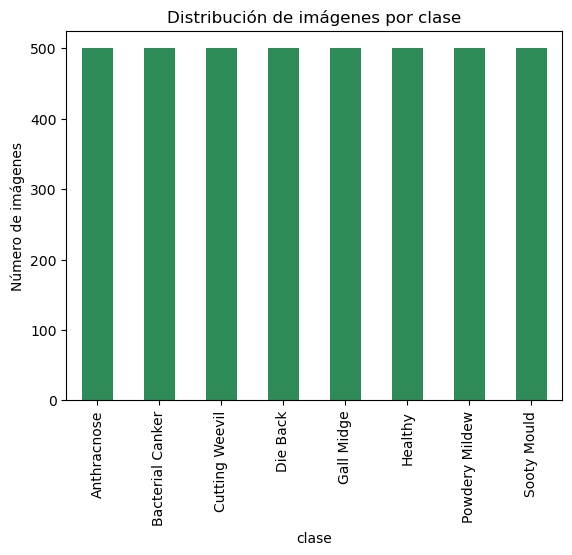

In [8]:
stats = []
for cls in classes:
    paths = []
    for ext in ("*.jpg","*.jpeg","*.png"):
        paths += glob.glob(os.path.join(root_dir, cls, ext))
    stats.append((cls, len(paths)))

df_stats = pd.DataFrame(stats, columns=["clase", "num_imagenes"])
display(df_stats)

df_stats.plot(kind='bar', x='clase', y='num_imagenes', legend=False, color='seagreen')
plt.title("Distribución de imágenes por clase")
plt.ylabel("Número de imágenes")
plt.show()

In [9]:
# Todas las imágenes se convierten a RGB y a un tamaño fijo (256x256).
# Esto facilita la extracción HOG.

IMG_SIZE = (256, 256)

def read_and_resize(path, size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        img = io.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size[1], size[0]), interpolation=cv2.INTER_AREA)
    return img


In [10]:
# EXTRACCIÓN DE CARACTERÍSTICAS HOG

def hog_features_from_path(path):
    img = read_and_resize(path)
    gray = color.rgb2gray(img)
    feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )
    return feat

# Construir dataset de vectores HOG
image_paths, labels = [], []
for cls in classes:
    for ext in ("*.jpg","*.jpeg","*.png"):
        for p in glob.glob(os.path.join(root_dir, cls, ext)):
            image_paths.append(p)
            labels.append(cls)

X = []
for p in tqdm(image_paths, desc="Extrayendo HOG"):
    X.append(hog_features_from_path(p))
X = np.array(X)
y = np.array(labels)

print("Dimensión del vector:", X.shape[1])

Extrayendo HOG: 100%|██████████| 4000/4000 [01:05<00:00, 60.94it/s]

Dimensión del vector: 8100


In [11]:
# DIVISIÓN DEL DATASET (TRAIN / VAL / TEST)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print("Tamaños:")
print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Tamaños:
Train: (2800, 8100)
Val  : (600, 8100)
Test : (600, 8100)


In [ ]:
#  ENTRENAMIENTO DEL MODELO KNN
knn_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", KNeighborsClassifier())
])

param_grid_knn = {
    "clf__n_neighbors": [3,5,7,11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1,2]  # Distancia Manhattan (1) o Euclidiana (2)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid_knn = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid_knn,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

In [16]:
print("Mejores parámetros KNN:", grid_knn.best_params_)
print("Mejor F1-macro (validación cruzada):", grid_knn.best_score_)

Mejores parámetros KNN: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
Mejor F1-macro (validación cruzada): 0.7984230336151208


In [15]:

#  EVALUACIÓN FINAL EN TEST

best_knn = grid_knn.best_estimator_
y_pred = best_knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print("\n RESULTADOS FINALES EN TEST:")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1:.4f}")
print("\nReporte detallado:\n")
print(classification_report(y_test, y_pred, digits=4))



 RESULTADOS FINALES EN TEST:
Accuracy: 0.8333
F1-macro: 0.8299

Reporte detallado:

                  precision    recall  f1-score   support

     Anthracnose     0.7500    0.6400    0.6906        75
Bacterial Canker     0.8182    0.9600    0.8834        75
  Cutting Weevil     1.0000    0.9733    0.9865        75
        Die Back     0.8202    0.9733    0.8902        75
      Gall Midge     0.7703    0.7600    0.7651        75
         Healthy     0.8182    0.7200    0.7660        75
  Powdery Mildew     0.8023    0.9200    0.8571        75
     Sooty Mould     0.9000    0.7200    0.8000        75

        accuracy                         0.8333       600
       macro avg     0.8349    0.8333    0.8299       600
    weighted avg     0.8349    0.8333    0.8299       600



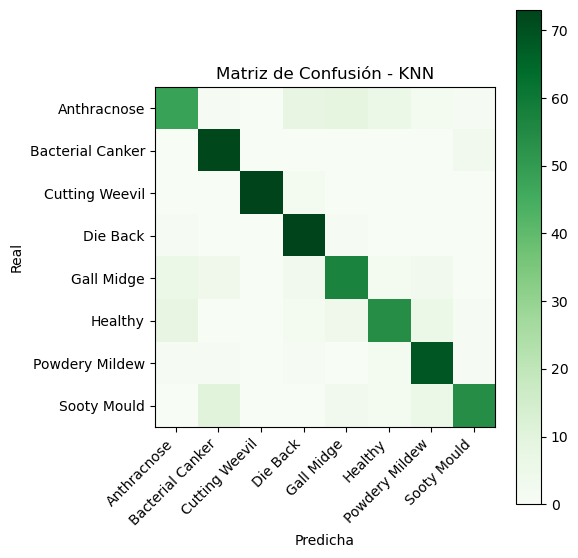

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Greens')
ax.set_title('Matriz de Confusión - KNN')
plt.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.tight_layout()
plt.show()